<a href="https://colab.research.google.com/github/YaoYinYing/low-n-protein-engineering/blob/master/Low-N_engineering_direct_evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Low-N protein engineering of P450

In [5]:
#@title Install softwares
import os
import glob
import pathlib
import sys
import time
import traceback
import pickle
import re
from IPython.utils import io
import subprocess
import tqdm.notebook
import urllib3
import gzip
from numba import jit

try:
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

JAX_UNIREP_REPO='https://github.com/ElArkk/jax-unirep.git'
DOWNLOAD_PFAM_SCRIPT='https://raw.githubusercontent.com/xqding/PEVAE_Paper/master/pfam_msa/script/download_MSA.py'
ENTREZ_URL='ftp://ftp.ncbi.nlm.nih.gov/entrez/entrezdirect//install-edirect.sh'

ROOT_DIR='.'
TMP_DIR = f"{ROOT_DIR}/tmp"

SCRIPTS_DIR=f'{TMP_DIR}/scripts'
FLAG_DIR=f'{TMP_DIR}/flag'
WEIGHTS_DIR=f'{TMP_DIR}/weights'

JOBS_DIR=f'{ROOT_DIR}/jobs'

RES_DIR=f'{ROOT_DIR}/results'
RES_DIR_MSA=f"{RES_DIR}/MSA"
RES_DIR_BLAST=f"{RES_DIR}/MSA/blast"
RES_DIR_FITNESS=f"{RES_DIR}/fitness"
RES_DIR_SEQ_OUT=f"{RES_DIR}/sequence_out"
RES_DIR_PICKLE=f'{RES_DIR}/pickle'
RES_DIR_REPORT=f'{RES_DIR}/report'
RES_DIR_FEATURE=f'{RES_DIR}/feature'
RES_DIR_FIGURE=f'{RES_DIR}/figure'
pathes=['/usr/local/cuda-11.4/bin']
libpathes=['/usr/local/cuda-11.4/lib64']

CONDA_PATH='/opt/anaconda3'

# if not already installed
total = 3
with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
  for dir in [ROOT_DIR,
              TMP_DIR,FLAG_DIR,WEIGHTS_DIR,SCRIPTS_DIR,
              JOBS_DIR,
              RES_DIR,RES_DIR_MSA,RES_DIR_BLAST,RES_DIR_FITNESS,RES_DIR_SEQ_OUT,RES_DIR_PICKLE,RES_DIR_REPORT,RES_DIR_FEATURE,RES_DIR_FIGURE]:
    os.makedirs(dir, exist_ok=True)
  pbar.update(1)

  for path in pathes:
    if f"{pathlib.Path(path).resolve()}" not in os.environ['PATH']:
      os.environ['PATH'] = f"{pathlib.Path(path).resolve()}:{os.environ['PATH']}"
  '''
  for path in libpathes:
    if f"{pathlib.Path(path).resolve()}" not in os.environ['LD_LIBRARY_PATH']:
      os.environ['LD_LIBRARY_PATH'] = f"{pathlib.Path(path).resolve()}:{os.environ['LD_LIBRARY_PATH'] }"
  '''
  pbar.update(1)


  # weights
  for p in ["tqdm","jax-unirep","biopython","awscli","optuna","seaborn","python-Levenshtein","feather-format"]:
    os.system(f'pip install {p}')
  pbar.update(1)
  

  0%|          | 0/3 [elapsed: 00:00 remaining: ?]

##Fetching data

In [8]:
#@title Fetching P450 data(210 MB for InterPro ?Did we fetch all the data?)
P450_FASTA_URL="https://raw.githubusercontent.com/YaoYinYing/low-n-protein-engineering/eb41191248895405aa47da6e70458d529fbe836a/data/IPR001128.fasta.tar.bz2"
os.system(f'wget -qnc {P450_FASTA_URL} -P {RES_DIR_MSA}')
os.system(f'cd {RES_DIR_MSA}; tar xjvf IPR001128.fasta.tar.bz2; mv IPR001128.fasta.tar.bz2 ..')


P450_TARGET_URL='https://raw.githubusercontent.com/YaoYinYing/low-n-protein-engineering/eb41191248895405aa47da6e70458d529fbe836a/data/890.fasta'
os.system(f'wget -qnc {P450_TARGET_URL} -P {JOBS_DIR}')

P450_BLAST_RES_URL='https://github.com/YaoYinYing/low-n-protein-engineering/raw/master/data/blast_res_890.fasta.tar.bz2'
os.system(f'wget -qnc {P450_BLAST_RES_URL} -P {RES_DIR_MSA} && cd {RES_DIR_MSA} &&  tar xvjf blast_res_890.fasta.tar.bz2')


P450_EXPERI_DATA_URL='https://github.com/YaoYinYing/low-n-protein-engineering/raw/master/data/P450_experi_data_encoded.csv'
os.system(f'wget -qnc {P450_EXPERI_DATA_URL} -P {RES_DIR_FITNESS}' )

target_fasta = f'{JOBS_DIR}/890.fasta'
target_fasta=pathlib.Path(target_fasta).resolve()
job_name=target_fasta.name

In [6]:
#@title Generate Inputs for Evotuning eUniRep for P450 family
# https://github.com/ivanjayapurna/low-n-protein-engineering/blob/master/pre-evotuning/generate_evotune_inputs_2MS2.ipynb

from Bio import SeqIO
import pandas as pd
import re
from Levenshtein import distance
import numpy as np
import matplotlib.pyplot as plt

## Clean sequence family and do a likelihood profiling

In [9]:
#@title Functions used

# read FASTA file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_fasta(name):
    # Yinying edited here bcs pfam provides stockholm formated file. 
    # PFam use stockholm while InterPro use fasta
    
    fasta_seqs = SeqIO.parse(open( name ), name.suffix.replace(".",''))
    data = []
    for fasta in fasta_seqs:
        data.append([fasta.id, str(fasta.seq).strip()])
    return data


# write FASTA file:
# input: file name; df to write
def write_fasta(name, seqs_df):
    out_file = open(f'{RES_DIR_SEQ_OUT}/{name}_out.fasta', "w")
    for i in range(len(seqs_df)):
        out_file.write('>' + seqs_df.name[i] + '\n')
        out_file.write(seqs_df.sequence[i] + '\n')
    out_file.close()


# input: takes in a sequence
# output: True if a sequence contains only standard amino acids, returns False if contains non-standard ones.
def validate(seq, pattern=re.compile(r'^[FIWLVMYCATHGSQRKNEPD]+$')):
    if (pattern.match(seq)):
        return True
    return False

    
# Remove sequences longer than k residues and with non-standard residues
# inputs: seqs_df = dataframe of name, sequence; k = max lenght of residues to keep
# output: cleaned dataframe
def clean(seqs_df, k):
    # remove sequences with length > 1000 AA's
    rows2drop = []
    for i in range(len(seqs_df)):
        if (len(seqs_df.sequence[i]) > k):
            rows2drop.append(i)

    print('Total number of sequences dropped due to length >', k, ':', len(rows2drop))

    seqs_df = seqs_df.drop(rows2drop).reset_index().drop('index', axis=1)

    print('Total number of sequences remaining:', len(seqs_df))
    
    # remove sequences with invalid AA residues
    # valid_alphabet = ['F','I','W','L','V','M','Y','C','A','T','H','G','S','Q','R','K','N','E','P','D']
    invalid_seqs = []

    for i in range(len(seqs_df)):
        if (not validate(seqs_df.sequence[i])):
            invalid_seqs.append(i)

    print('Total number of invalid sequences dropped:', len(invalid_seqs))

    seqs_df = seqs_df.drop(invalid_seqs).reset_index().drop('index', axis=1)

    print('Total number of valid sequences remaining:', len(seqs_df))
    
    
    seqs_df = seqs_df.drop_duplicates(subset='sequence').reset_index().drop('index', axis=1)

    print('Total sequences remaining after duplicate removal', len(seqs_df))

    
    return seqs_df


# calculate the Levenstein distance of mulitple sequences to a target sequence
# also plots a histogram of distances
# inputs: t_seq = target sequence; seqs_df = dataframe of sequences;
# num_bins = bins for histogram; hist_range = range for histogram
# outputs: numpy array of distances
def lev_dist(t_seq, seqs_df, num_bins=20, hist_range=(0,350)):
    distances = []
    for i in range(len(seqs_df)):
        distances.append(distance(t_seq, seqs_df.sequence[i]))
    distances = np.array(distances)

    mean_dist = np.mean(distances)
    median_dist = np.median(distances)
    min_dist = np.min(distances)
    max_dist = np.max(distances)
    
    print("Mean Levenstein distance:", mean_dist)
    print("Median Levenstein distance:", mean_dist)
    print("Min Levenstein distance:", min_dist)
    print("Max Levenstein distance:", max_dist)

    
    # histogram of Levenstein distances from target sequence
    plt.clf()
    plt.hist(distances, bins=num_bins, range=hist_range)
    plt.show()
    
    return distances



"""
File formatting note.
Data should be preprocessed as a sequence of comma-seperated ints with
sequences  /n seperated
"""

# Lookup tables
aa_to_int = {
    'M':1,
    'R':2,
    'H':3,
    'K':4,
    'D':5,
    'E':6,
    'S':7,
    'T':8,
    'N':9,
    'Q':10,
    'C':11,
    'U':12,
    'G':13,
    'P':14,
    'A':15,
    'V':16,
    'I':17,
    'F':18,
    'Y':19,
    'W':20,
    'L':21,
    'O':22, #Pyrrolysine
    'X':23, # Unknown
    'Z':23, # Glutamic acid or GLutamine
    'B':23, # Asparagine or aspartic acid
    'J':23, # Leucine or isoleucine
    'start':24,
    'stop':25,
}

int_to_aa = {value:key for key, value in aa_to_int.items()}

def get_aa_to_int():
    """
    Get the lookup table (for easy import)
    """
    return aa_to_int

def get_int_to_aa():
    """
    Get the lookup table (for easy import)
    """
    return int_to_aa
    
def aa_seq_to_int(s):
    """
    Return the int sequence as a list for a given string of amino acids
    """
    return [24] + [aa_to_int[a] for a in s] + [25]

def int_seq_to_aa(s):
    """
    Return the int sequence as a list for a given string of amino acids
    """
    return "".join([int_to_aa[i] for i in s])

    
def format_seq(seq,stop=False):
    """
    Takes an amino acid sequence, returns a list of integers in the codex of the babbler.
    Here, the default is to strip the stop symbol (stop=False) which would have 
    otherwise been added to the end of the sequence. If you are trying to generate
    a rep, do not include the stop. It is probably best to ignore the stop if you are
    co-tuning the babbler and a top model as well.
    """
    if stop:
        int_seq = aa_seq_to_int(seq.strip())
    else:
        int_seq = aa_seq_to_int(seq.strip())[:-1]
    return int_seq

def is_valid_seq(seq, max_len=2000):
    """
    True if seq is valid for the babbler, False otherwise.
    """
    l = len(seq)
    valid_aas = "MRHKDESTNQCUGPAVIFYWLO"
    if (l < max_len) and set(seq) <= set(valid_aas):
        return True
    else:
        return False

def fasta_to_input(in_path):
    source = SeqIO.parse(in_path + '.fasta.txt','fasta')
    with open(in_path + "_formatted.fasta.txt", "w") as destination:
        for seq in fasta_seqs:
            seq = seq.strip()
            if is_valid_seq(seq) and len(seq) < 275: 
                formatted = ",".join(map(str,format_seq(seq)))
                destination.write(formatted)
                destination.write('\n')

def seqs_to_input(name, in_seqs, stop=False):
    with open('outputs/' + name + "_formatted.fasta.txt", "w") as destination:
        for seq in in_seqs:
            seq = seq.strip()
            if is_valid_seq(seq): 
                formatted = ",".join(map(str,format_seq(seq, stop=stop)))
                destination.write(formatted)
                destination.write('\n')

In [ ]:
!echo $CONDA_PREFIX

/opt/anaconda3


## Fetch pretrained models of evoltuning P450

In [7]:
#@title download pre-trained P450 evotuning model
for model in ['evotuning_P450_from_randinit','evotuning_P450_from_global']:
    EVOLTUNING_MODEL_URL=f'https://raw.githubusercontent.com/YaoYinYing/low-n-protein-engineering/master/data/feature/{model}/iter_0/model_weights.pkl'
    MODEL_DIR=f'{RES_DIR_FEATURE}/{model}/iter_0/'
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.system(f'wget -qnc {EVOLTUNING_MODEL_URL} -P {MODEL_DIR}')

In [11]:
#@title Top Training w/ fitness data

from jax_unirep import get_reps, fit
from jax_unirep.utils import load_params
from Bio import SeqIO
import pandas as pd
import glob
import os
import numpy as np

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV, LinearRegression, HuberRegressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore') 

from sklearn.preprocessing import normalize, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import feather


def read_labeled_data(fitness_csv,seq_col,fit_col): 
  df=pd.read_csv(pathlib.Path(fitness_csv),usecols=[seq_col,fit_col])
  data = []
  for seq, fitness in zip(df.loc[:, seq_col], df.loc[:, fit_col]):
        data.append([str(seq).strip(), fitness])
  return data
# data=read_labeled_data("./P450_experi_data_encoded.csv",'Seq','11H-Cuol')


# save represented dataframe of features as feather
def save_reps(df, path):
  feather.write_dataframe(df, path + '.feather')
  print(path + '.feather', 'saved!')


# read represented dataframe of features as feather
def read_reps(path):
  return feather.read_dataframe(path + '.feather')


def _one_hot(x, k, dtype=np.float32):
  # return np.array(x[:, None] == np.arange(k), dtype)
  return np.array(x[:, None] == np.arange(k))


def aa_seq_to_int(s):
  """Return the int sequence as a list for a given string of amino acids."""
  # Make sure only valid aa's are passed
  if not set(s).issubset(set(aa_to_int.keys())):
    raise ValueError(
      f"Unsupported character(s) in sequence found:"
      f" {set(s).difference(set(aa_to_int.keys()))}"
    )

  return [aa_to_int[a] for a in s]


def aa_seq_to_onehot(seq):
  return 1*np.equal(np.array(aa_seq_to_int(seq))[:,None], np.arange(21)).flatten()
  

def multi_onehot(seqs):
  return np.stack([aa_seq_to_onehot(s) for s in seqs.tolist()])


def distance_matrix(N):
	#A is the one who works with the distance_matrix = np.zeros((N,N))
	for i in range(N):
		for j in range(N):
			# distance_matrix[i,j]=1- ((abs(i-j)/N)**2)
			distance_matrix[i,j]= 1-(abs(i-j)/N)

	return distance_matrix


def confusion_matrix_loss(Y_test,Y_preds_test):

  N = len(Y_test)
  Y_rank_matrix = np.zeros((N,N))
  Y_preds_rank_matrix = np.zeros((N,N))
  for i in range(N):
    for j in range(N):

      if Y_test[i] > Y_test[j]:
        Y_rank_matrix[i,j] = 1
      elif Y_test[i] <= Y_test[j]:
        Y_rank_matrix[i,j] = 0
      if Y_preds_test[i] > Y_preds_test[j]:
        Y_preds_rank_matrix[i,j] = 1
      elif Y_preds_test[i] <= Y_preds_test[j]:
        Y_preds_rank_matrix[i,j] = 0
  confusion_matrix = ~(Y_preds_rank_matrix == Y_rank_matrix)
  # dist_mat = distance_matrix(N)
  # confusion_matrix = confusion_matrix*dist_mat
  loss = np.sum(confusion_matrix)/confusion_matrix.size

  return loss

In [12]:
#@title  load labeled training data
col_seq='Seq' #@param {type:"string"}
col_fitness='11H-Cuol' #@param {type:"string"}
seqs_df = pd.DataFrame(read_labeled_data(f"{RES_DIR_FITNESS}/P450_experi_data_encoded.csv",col_seq,col_fitness), columns = ['sequence', 'fitness'])

In [13]:
#@title read P450 890 sequence
target_sequence=read_fasta(target_fasta)[0][1]
target_sequence

'MWTILLGLATLAIAYYIHWVNKWKDSKFNGVLPPGTMGLPLIGETIQLSRPSDSLDVHPFIQRKVKRYGPIFKTCLAGRPVVVSTDAEFNHYIMLQEGRAVEMWYLDTLSKFFGLDTEWLKALGLIHKYIRSITLNHFGAESLRERFLPRIEESARETLHYWSTQTSVEVKESAAAMVFRTSIVKMFSEDSSKLLTEGLTKKFTGLLGGFLTLPLNLPGTTYHKCIKDMKQIQKKLKDILEERLAKGVKIDEDFLGQAIKDKESQQFISEEFIIQLLFSISFASFESISTTLTLILNFLADHPDVVKELEAEHEAIRKARADPDGPITWEEYKSMNFTLNVICETLRLGSVTPALLRKTTKEIQIKGYTIPEGWTVMLVTASRHRDPEVYKDPDTFNPWRWKELDSITIQKNFMPFGGGLRHCAGAEYSKVYLCTFLHILFTKYRWRKLKGGKIARAHILRFEDGLYVNFTPKE'

In [14]:
#@title  define hyper params 
PROJECT_NAME='evotuning_P450_from'

gdrive_path=f'{RES_DIR_PICKLE}/'
DIR_PATH = f'{RES_DIR_FEATURE}/{PROJECT_NAME}'
#os.system(f'mkdir -p {pathlib.Path(DIR_PATH).resolve()}')

PARAMS = [ '_global/iter_0','_randinit/iter_0',None, 'one_hot',]

# get representations of data for each params:
N_seqs = len(seqs_df)
print("N_seqs:", N_seqs)

# vary batches based on memory available (i.e. if you have less memory run more batches)
# this google colab can handle around 1000 seqs per batch for sure
N_BATCHES = 6

BATCH_LEN = int(np.ceil(N_seqs/N_BATCHES))

for param in PARAMS:
  # append path to param unless unirep (no param)
  if param == 'one_hot':
    print('getting reps for one hot')
    onehot = multi_onehot(seqs_df.sequence)
    feat_cols = [ 'feat' + str(j) for j in range(1, onehot.shape[1] + 1) ]
    this_df = pd.DataFrame(onehot, columns=feat_cols)
    this_df.insert(0, "sequence", seqs_df.sequence)
    this_df.insert(1, "fitness", seqs_df.fitness)

    save_reps(this_df, gdrive_path + 'one_hot')

    continue

  elif param is None:
    name = 'unirep'

  else:
    name = f'{PROJECT_NAME}-{param}'.replace("/",'_')
    # param is the second element of returned tuple
    # fixed by Yinying
    param = load_params(DIR_PATH + param)[1]

  print('getting reps for', name)
  #print(param)
  # get 1st sequence
  reps, _, _ = get_reps(seqs_df.sequence[0], params=param)
  feat_cols = [ 'feat' + str(j) for j in range(1, reps.shape[1] + 1) ]
  this_df = pd.DataFrame(reps, columns=feat_cols)
  this_df.insert(0, "sequence", seqs_df.sequence[0])
  this_df.insert(1, "fitness", seqs_df.fitness[0])

  # get the rest in batches
  for i in range(N_BATCHES):
    this_unirep, _, _ = get_reps(seqs_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ] , params=param)
    this_unirep_df = pd.DataFrame(this_unirep, columns=feat_cols)
    this_unirep_df.insert(0, "sequence", seqs_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
    this_unirep_df.insert(1, "fitness", seqs_df.fitness[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
    this_df = pd.concat([this_df.reset_index(drop=True), this_unirep_df.reset_index(drop=True)]).reset_index(drop=True)

  save_reps(this_df, gdrive_path + name)

N_seqs: 84
getting reps for evotuning_P450_from-_global_iter_0
./results/pickle/evotuning_P450_from-_global_iter_0.feather saved!
getting reps for evotuning_P450_from-_randinit_iter_0
./results/pickle/evotuning_P450_from-_randinit_iter_0.feather saved!
getting reps for unirep
./results/pickle/unirep.feather saved!
getting reps for one hot
./results/pickle/one_hot.feather saved!


In [15]:
#@title load the reps you want into dataframes
FEATHER_PATH = gdrive_path 

unirep_df = read_reps(FEATHER_PATH + 'unirep')
eunirep_df = read_reps(FEATHER_PATH + 'evotuning_P450_from-_global_iter_0')
rand_eunirep_df=read_reps(FEATHER_PATH + 'evotuning_P450_from-_randinit_iter_0')
onehot_df = read_reps(FEATHER_PATH + 'one_hot')

dfs = [unirep_df, eunirep_df, onehot_df,rand_eunirep_df]
df_names = ['unirep', 'eunirep', 'one hot','rand_eunirep']

  0%|          | 0/32 [elapsed: 00:00 remaining: ?]

<Figure size 432x288 with 0 Axes>

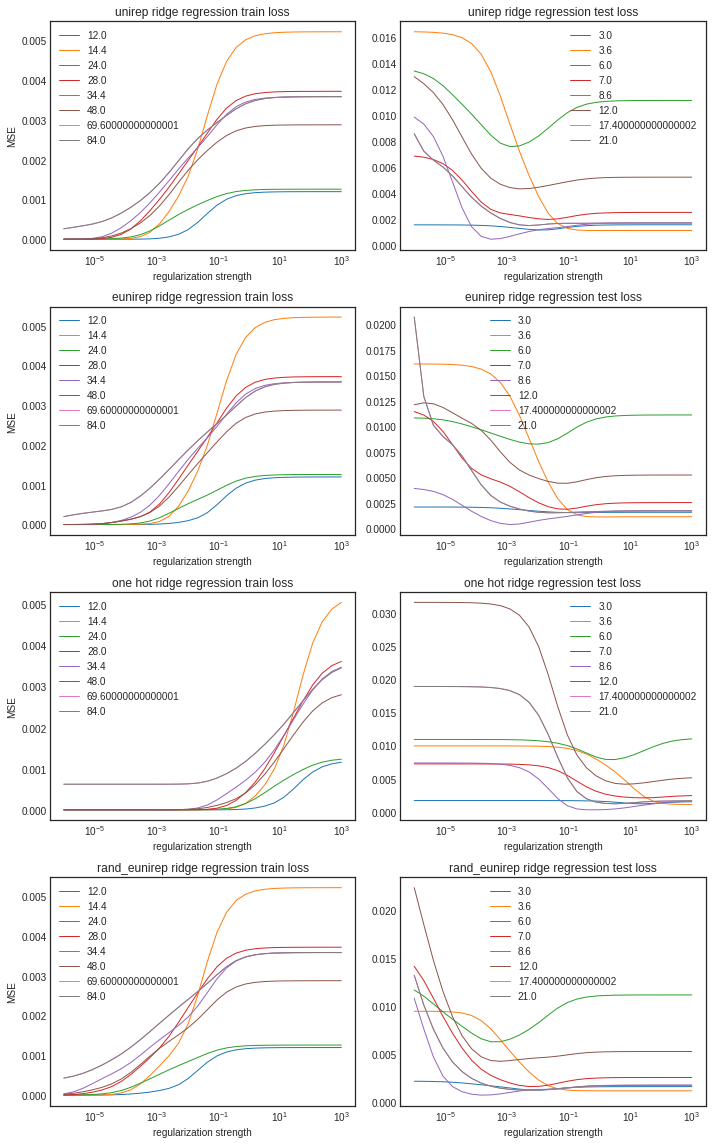

In [16]:
#@title randomly select subset of sequence as input data
np.random.seed(42)
rndperm = np.random.permutation(dfs[0].shape[0])

BATCH_SIZES = [12,15,24,28,35,48,70,84]
batch_size_list = (np.array(BATCH_SIZES)/0.8).astype("int")

plt.clf()

fig = plt.figure(figsize=(10,4*len(dfs)))
plt.style.use('seaborn-white')
alpha_vals = np.logspace(-6,3,30)

total=len(dfs)*len(batch_size_list)
pbar=tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT)

for i in range(len(dfs)):
    ax1 = fig.add_subplot(len(dfs),2,(2*i+1), title=df_names[i] + " ridge regression train loss")
    ax2 = fig.add_subplot(len(dfs),2,(2*i+2), title=df_names[i] + " ridge regression test loss")
    
    df = dfs[i]
    for batch_size in batch_size_list:
        pbar.update(1)
        X = df.loc[rndperm[:batch_size], df.columns[2:]]
        Y = df.loc[rndperm[:batch_size], "fitness"]

        
        alpha_list = []
        train_loss_list = []
        test_loss_list = []
        
        for alpha_i in alpha_vals:
            #print(f'df\t{i}: \tbatch_size\t{batch_size}\talpha_i\t{alpha_i}')
            
            # train-test split for both 
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

            # ridge regression model setup
            kfold = KFold(n_splits=10, random_state=42, shuffle=True)

            model = RidgeCV(alphas=[alpha_i], cv=kfold)

            # fit the model
            model.fit(X_train, Y_train)

            # predict fitness to get train and test losses
            Y_train_preds = model.predict(X_train)
            Y_test_preds = model.predict(X_test)

            # train_loss = np.linalg.norm(Y_train_preds - Y_train)
            # test_loss = np.linalg.norm(Y_test_preds - Y_test)
            train_loss = np.mean((Y_train_preds - Y_train)**2)
            test_loss = np.mean((Y_test_preds - Y_test)**2)

            alpha_list.append(model.alpha_)
            train_loss_list.append(train_loss)
            test_loss_list.append(test_loss)
        '''
        print(f'')
        print(f'alpha_list={alpha_list}')
        print(f'train_loss_list={train_loss_list}')
        print(f'test_loss_list={test_loss_list}')
        '''
        # plot train and test losses
        ax1.plot(alpha_list, train_loss_list,linewidth=1)
        ax2.plot(alpha_list, test_loss_list,linewidth=1)

    ax1.legend(batch_size_list*0.8)
    ax1.set_xscale("log")
    ax1.set_xlabel("regularization strength")
    ax1.set_ylabel("MSE")
    ax2.legend(batch_size_list*0.2)
    ax2.set_xscale("log")
    ax2.set_xlabel("regularization strength")
    ax1.set_ylabel("MSE")

plt.tight_layout()
plt.show()

  0%|          | 0/8 [elapsed: 00:00 remaining: ?]

<Figure size 432x288 with 0 Axes>

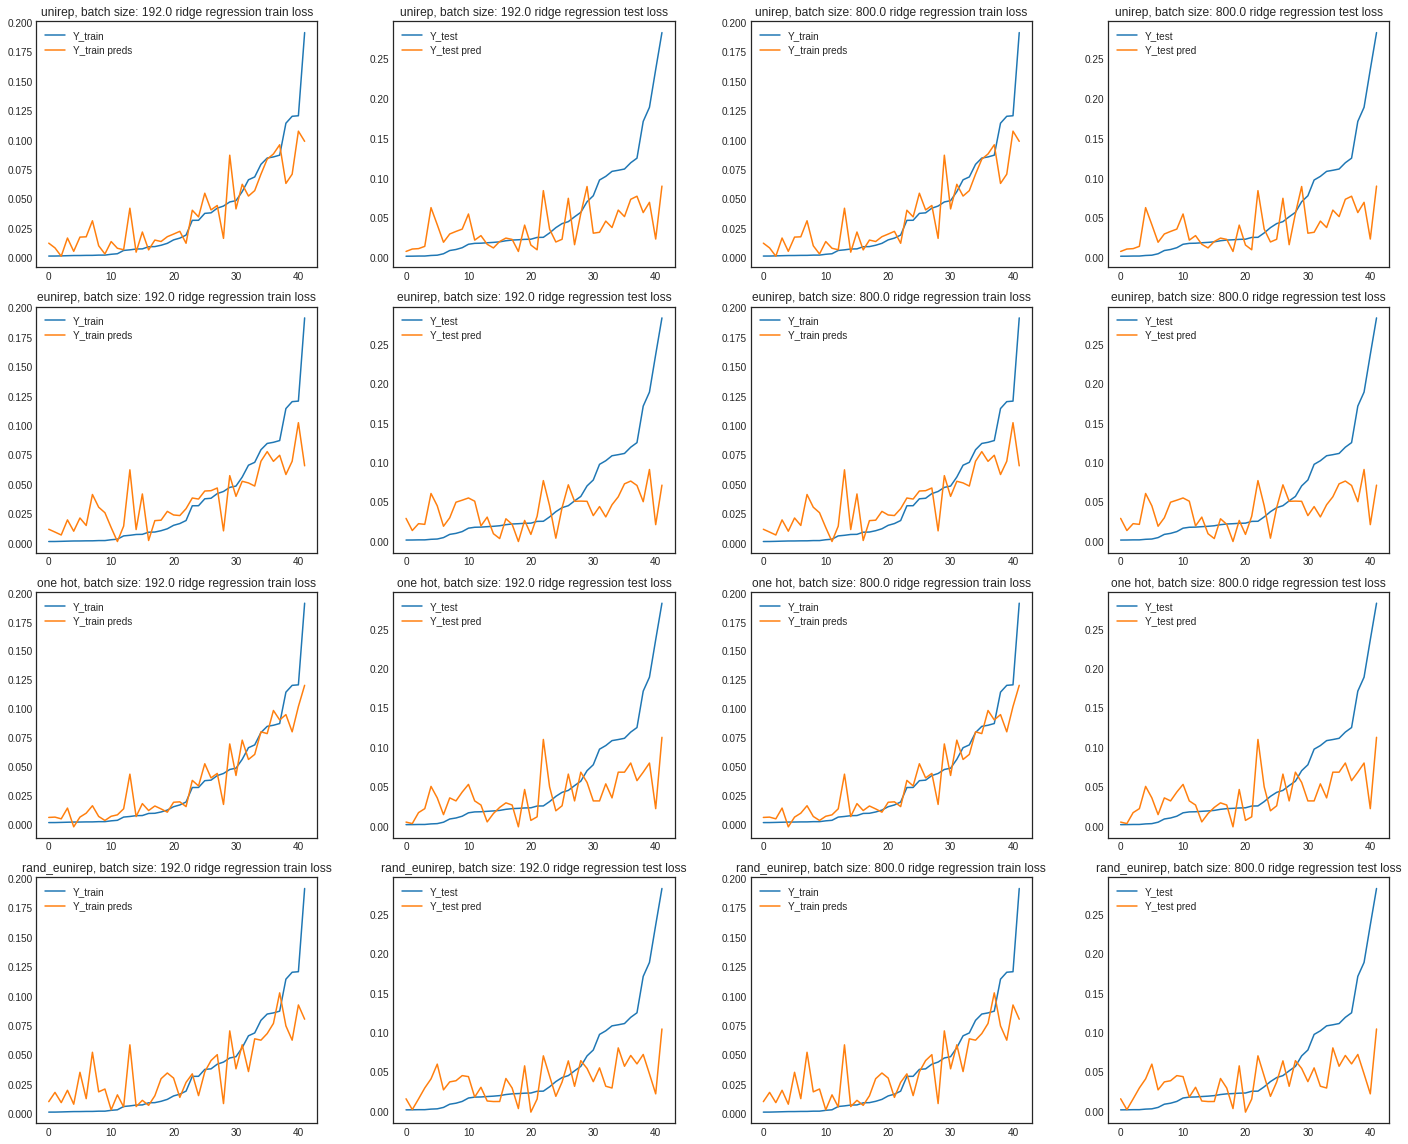

In [21]:
#@title Train for selected hyper parameters
# HYPER_PARAM
ALPHAS = [ 0.001, 0.015,1,0.001]
# ALPHAS = [ 0.0001, 0.00015,1,0.0001]

BATCH_SIZES = [96*2,800]
SPLIT = 0.5

batch_size_list = (np.array(BATCH_SIZES)/SPLIT).astype("int")

# randomly select subset of sequence as input data
np.random.seed(42)
rndperm = np.random.permutation(dfs[0].shape[0])

plt.clf()

fig = plt.figure(figsize=(10*len(BATCH_SIZES) ,4*len(dfs)))
plt.style.use('seaborn-white')

total=len(dfs)*len(batch_size_list)
pbar=tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT)
for i in range(len(dfs)):

  df = dfs[i]
  for j in range(len(batch_size_list)):
    pbar.update(1)
    X = df.loc[rndperm[:batch_size_list[j]], df.columns[2:]]
    Y = df.loc[rndperm[:batch_size_list[j]], "fitness"]

    # train-test split for both 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=SPLIT, random_state=1717)

    # ridge regression model setup
    kfold = KFold(n_splits=10, random_state=1717, shuffle=True)

    model = RidgeCV(alphas=[ALPHAS[i]], cv=kfold)

    # fit the model
    model.fit(X_train, Y_train)

    # predict fitness to get train and test losses
    Y_train_preds = model.predict(X_train)
    Y_test_preds = model.predict(X_test)

    # train_loss = np.linalg.norm(Y_train_preds - Y_train)
    # test_loss = np.linalg.norm(Y_test_preds - Y_test)
    train_loss = np.mean((Y_train_preds - Y_train)**2)
    test_loss = np.mean((Y_test_preds - Y_test)**2)

    ax1 = fig.add_subplot(len(dfs),len(BATCH_SIZES)*2,(4*i+2*j+1), title=df_names[i] + ", batch size: " + str(batch_size_list[j]*(1-SPLIT)) + " ridge regression train loss")
    ax1.plot(np.arange(len(Y_train)), np.array(Y_train)[np.argsort(Y_train)])
    ax1.plot(np.arange(len(Y_train)), np.array(Y_train_preds)[np.argsort(Y_train)])
    ax1.legend(['Y_train','Y_train preds'])

    ax2 = fig.add_subplot(len(dfs),len(BATCH_SIZES)*2,(4*i+2*j+2), title=df_names[i] + ", batch size: " + str(batch_size_list[j]*SPLIT) + " ridge regression test loss")
    ax2.plot(np.arange(len(Y_test)), np.array(Y_test)[np.argsort(Y_test)])
    ax2.plot(np.arange(len(Y_test)), np.array(Y_test_preds)[np.argsort(Y_test)])
    ax2.legend(['Y_test','Y_test pred'])

plt.tight_layout()
plt.show()

[10, 15, 20, 25, 30, 35, 40]


  0%|          | 0/28 [elapsed: 00:00 remaining: ?]

  0%|          | 0/560 [elapsed: 00:00 remaining: ?]

  0%|          | 0/56000 [elapsed: 00:00 remaining: ?]

unirep [0.8116883116883117, 1.2066365007541477, 1.2779552715654952, 1.2232415902140672, 1.08359133126935, 1.2232415902140672, 1.355421686746988, 1.228878648233487, 1.36986301369863, 1.1678832116788322, 0.9508716323296356, 1.3493253373313343, 1.5797788309636651, 1.4195583596214512, 1.1730205278592374, 1.225114854517611, 1.0736196319018405, 1.1627906976744187, 1.5600624024960998, 1.2517385257301807] Mean Score: 1.2347140978244426
eunirep [1.2987012987012987, 1.3574660633484164, 1.597444089456869, 1.2232415902140672, 1.238390092879257, 1.3761467889908257, 1.355421686746988, 1.228878648233487, 1.21765601217656, 1.3138686131386863, 1.109350237717908, 1.0494752623688155, 1.4218009478672986, 1.2618296529968454, 1.3196480938416422, 1.225114854517611, 1.2269938650306749, 1.0174418604651163, 1.4040561622464898, 1.2517385257301807] Mean Score: 1.274733217333452
one hot [1.1363636363636362, 1.3574660633484164, 1.4376996805111821, 1.3761467889908257, 1.238390092879257, 1.3761467889908257, 1.3554216

<Figure size 432x288 with 0 Axes>

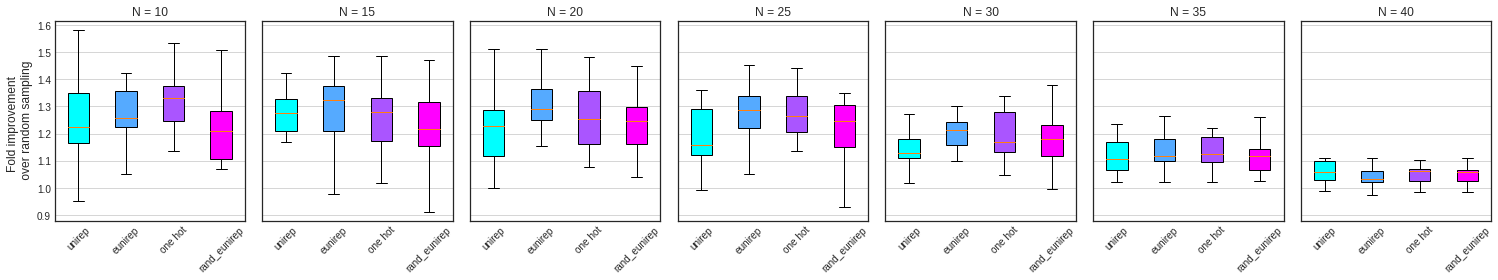

In [22]:
#@title ridge regression improvement over random sampling
'''
# number of batches to test
N_BATCH = 200

# number of sequences per training batch
TRAIN_BATCH_SIZES = [10, 15,20]

# number of random trials to perform for baseline
N_RAND_BATCHES = 100
'''


# number of batches to test
N_BATCH = 20

# number of sequences per training batch
TRAIN_BATCH_SIZES = [10,15,20,25,30,35,40] 
print(TRAIN_BATCH_SIZES)
# number of random trials to perform for baseline
N_RAND_BATCHES = 100

# wild-type fitness
WT_FIT = 0.0121563


total1=len(TRAIN_BATCH_SIZES)*len(dfs)
pbar1=tqdm.notebook.tqdm(total=total1, bar_format=TQDM_BAR_FORMAT)

total2=len(TRAIN_BATCH_SIZES)*len(dfs)*N_BATCH
pbar2=tqdm.notebook.tqdm(total=total2, bar_format=TQDM_BAR_FORMAT)

total3=len(TRAIN_BATCH_SIZES)*len(dfs)*N_BATCH*N_RAND_BATCHES
pbar3=tqdm.notebook.tqdm(total=total3, bar_format=TQDM_BAR_FORMAT)

batch_level = []
for TRAIN_BATCH_SIZE in TRAIN_BATCH_SIZES:

  # number of sequences per holdout batch
  HOLDOUT_BATCH_SIZE = TRAIN_BATCH_SIZE*10

  params_level = []
  for j in range(len(dfs)):
    pbar1.update(1)
    df = dfs[j]

    scores_level = []
    for i in range(N_BATCH):
      pbar2.update(1)
      # change random seed for each batch
      np.random.seed(42*(i+2))
      rndperm = np.random.permutation(df.shape[0])

      # data setup
      X = df.loc[rndperm[0:TRAIN_BATCH_SIZE], df.columns[2:]]
      Y = df.loc[rndperm[0:TRAIN_BATCH_SIZE], "fitness"]

      X_holdout = df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], df.columns[2:]]
      Y_holdout = df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], "fitness"]

      # ridge regression model setup
      kfold = KFold(n_splits=10, shuffle=True)

      model = RidgeCV(alphas=[ALPHAS[j]], cv=kfold)

      # fit the model
      model.fit(X, Y)

      # use model to sort holdout set and get top TRAIN_BATCH_SIZE predicted fitness
      Y_preds = model.predict(X_holdout)

      usorted = np.array(Y_holdout)[np.argsort(Y_preds)][::-1][:int(HOLDOUT_BATCH_SIZE/10)]

      # Note: wild-type fitness = WT_FIT (thats the scoring metric)
      usorted_count = np.sum([1 if i > WT_FIT else 0 for i in usorted])

      # randomly shuffle holdout set RAND_BATCHES time
      # and take average of top TRAIN_BATCH_SIZE fitness
      avg_rand_count = 0
      for k in range(N_RAND_BATCHES):
        pbar3.update(1)
        np.random.seed(42*(i+2) + (1+k))
        rand_Y = np.random.permutation(np.array(Y_holdout))[:int(HOLDOUT_BATCH_SIZE/10)]
        avg_rand_count += np.sum([1 if i > WT_FIT else 0 for i in rand_Y])
      avg_rand_count /= N_RAND_BATCHES

      # final score ratio:
      scores_level.append(usorted_count/avg_rand_count)

    print(df_names[j], scores_level, "Mean Score:", np.mean(scores_level))
    params_level.append(scores_level)

  batch_level.append(params_level)


plt.clf()
ax_dict = {}
fig, axes = plt.subplots(nrows=1, ncols=len(TRAIN_BATCH_SIZES), sharey=True, figsize=(3*len(TRAIN_BATCH_SIZES),4))

for i in range(len(TRAIN_BATCH_SIZES)):
  ax_dict[i] = axes[i].boxplot(np.array(batch_level[i]).transpose(), showfliers=False,patch_artist=True)
  axes[i].set_title("N = "+str(TRAIN_BATCH_SIZES[i]))
  axes[i].set_xticklabels(df_names,rotation=45)
  
axes[0].set_ylabel("Fold improvement \n over random sampling",size = 12)

color_idx = np.linspace(0, 1, len(df_names))
for ax_ind in range(len(ax_dict)):
  for patch, i in zip(ax_dict[ax_ind]['boxes'], color_idx):
    patch.set_facecolor(plt.cm.cool(i))

for ax in axes:
    ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

# Direct Evolution in silico

In [23]:
#@title load functions
from jax_unirep import get_reps, fit
# edited by Yinying
from jax_unirep.utils import load_params
from Bio import SeqIO
import pandas as pd
import glob
import os
from pathlib import Path
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV

import warnings
warnings.filterwarnings('ignore') 

import matplotlib.pyplot as plt
import seaborn as sns
import feather
import random

In [24]:
#@title define functions
def get_top_model(df, alpha, train_batch_size):

  rand_state_num = 42

  np.random.seed(rand_state_num)

  rndperm = np.random.permutation(df.shape[0])

  X_train = df.loc[rndperm[:train_batch_size], df.columns[2:]]
  Y_train = df.loc[rndperm[:train_batch_size], "fitness"]

  kfold = KFold(n_splits=10, random_state=rand_state_num, shuffle=True)

  return RidgeCV(alphas=alpha, cv=kfold).fit(X_train, Y_train)

def init_by_rep(df, alpha_val, N, param_file):

  if param_file == None:
    params = load_params(None)[1]
    DE_model = get_top_model(df, [alpha_val], N) # choose unirep representation, alpha=1e-3, and 96 training mutants


  else: # if we want to use an evotuned representation:
    params = load_params(param_file)[1]
    DE_model = get_top_model(df, [alpha_val], N) # choose eunirep representation, alpha=1e-3, and 96 training mutants

  return params, DE_model


def mutate_sequence(seq,m,prev_mut_loc): # produce a mutant sequence (integer representation), given an initial sequence and the number of mutations to introduce ("m")

  for i in range(m): #iterate through number of mutations to add
    rand_loc = random.randint(prev_mut_loc-8,prev_mut_loc+8) # find random position to mutate
    while (rand_loc <=0) or (rand_loc >= len(seq)):
      rand_loc = random.randint(prev_mut_loc-8,prev_mut_loc+8)

    rand_aa = random.randint(1,21) # find random amino acid to mutate to
    seq = list(seq)
    seq[rand_loc] = get_int_to_aa()[rand_aa] # update sequence to have new amino acid at randomely chosen position
    seq = ''.join(seq)


  return seq,rand_loc # output the randomely mutated sequence

def directed_evolution(s_wt,num_iterations,T,Model, params): # input = (wild-type sequence, number of mutation iterations, "temperature")		


  s_traj = [] # initialize an array to keep records of the protein sequences for this trajectory
  y_traj = [] # initialize an array to keep records of the fitness scores for this trajectory


  mut_loc_seed = random.randint(0,len(s_wt)) # randomely choose the location of the first mutation in the trajectory
  s,new_mut_loc = mutate_sequence(s_wt, (np.random.poisson(2) + 1),mut_loc_seed) # initial mutant sequence for this trajectory, with m = Poisson(2)+1 mutations

  x,_,_ = get_reps([s],params=params)# eUniRep representation of the initial mutant sequence for this trajectory

  y = Model.predict(x) # predicted fitness score for the initial mutant sequence for this trajectory


  # iterate through the trial mutation steps for the directed evolution trajectory
  for i in range(num_iterations):
    mu = np.random.uniform(1,2.5) # "mu" parameter for poisson function: used to control how many mutations to introduce
    m = np.random.poisson(mu-1) + 1 # how many random mutations to apply to current sequence

    s_new,new_mut_loc = mutate_sequence(s, m, new_mut_loc) # new trial sequence, produced from "m" random mutations

    x_new,_,_ = get_reps([s_new],params=params)

    y_new = Model.predict(x_new) # new fitness value for trial sequence

    p = min(1,np.exp((y_new-y)/T)) # probability function for trial sequence
    rand_var = random.random()

    if rand_var < p: # metropolis-Hastings update selection criterion
      print(str(new_mut_loc+1)+" "+s[new_mut_loc]+"->"+s_new[new_mut_loc])
      s, y = s_new, y_new # if criteria is met, update sequence and corresponding fitness

    s_traj.append(s) # update the sequence trajectory records for this iteration of mutagenesis
    y_traj.append(y) # update the fitness trajectory records for this iteration of mutagenesis


  return s_traj, y_traj # output = (sequence record for trajectory, fitness score recorf for trajectory)

def minibatches(inputs_data, batch_size):
    # fix data losing with minibatches
    for start_idx in range(0, len(inputs_data), batch_size):
        if len(inputs_data[start_idx:])>batch_size:
            excerpt = slice(start_idx, start_idx + batch_size)
            #print("yielding data len: %s" % len(inputs_data[excerpt]))
            yield inputs_data[excerpt]

        else:
            #print("yielding final data len: %s" % len(inputs_data[start_idx:]))
            yield inputs_data[start_idx:]

def run_DE_trajectories(s_wt, Model, T, num_iterations, num_trajectories, DE_record_folder,params,save=False):

  s_records = [] # initialize list of sequence records
  y_records = [] # initialize list of fitness score records

  for i in range(num_trajectories): #iterate through however many mutation trajectories we want to sample
    s_traj, y_traj = directed_evolution(s_wt,num_iterations,T,Model,params) # call the directed evolution function, outputting the trajectory sequence and fitness score records

    s_records.append(s_traj) # update the sequence trajectory records for this full mutagenesis trajectory
    y_records.append(y_traj) # update the fitness trajectory records for this full mutagenesis trajectory

    if save==True:
      # iteration_path = directory_path+"DE_records/"
      np.savetxt(DE_record_folder + "/trajectory"+str(i)+"_seqs.txt", np.array(s_traj),fmt="%s")   # save sequence records for trajectory-i
      np.savetxt(DE_record_folder + "/trajectory"+str(i)+"_fitness.txt", np.array(y_traj))   # save fitness records for trajecroty-i
    print("finished trajectory #",i)

  s_records = np.array(s_records)
  y_records = np.array(y_records)
  
  c=0
  for y_record in minibatches(y_records[:,:,0],5):
      
      plt.clf()
      fig = plt.figure(figsize=(10,6))
      plt.plot(np.transpose(y_record)) # plot the changes in fitness for all sampled trajectories
      plt.ylabel('Predicted Fitness')
      plt.xlabel('Mutation Trial Steps')
      plt.legend([f'trajectory {x}' for x in range(c*5,(c+1)*5)],fontsize=14)
      plt.savefig(f"{RES_DIR_FIGURE}/DE_{c*5+1}_{(c+1)*5}.png")
      plt.show() # show the plot :)
      #
      c+=1

  return s_records, y_records

In [25]:
seqs_df = pd.DataFrame(read_labeled_data(f"{RES_DIR_FITNESS}/P450_experi_data_encoded.csv",col_seq,col_fitness), columns = ['sequence', 'fitness'])

df = read_reps(FEATHER_PATH + 'evotuning_P450_from-_global_iter_0')

param_file=f'{RES_DIR_FEATURE}/evotuning_P450_from_global/iter_0'
print(param_file)


./results/feature/evotuning_P450_from_global/iter_0


In [26]:
alpha = 0.0015

BATCH_SIZE = 42

rand_state_num = 42

In [27]:
np.random.seed(rand_state_num)
rndperm = np.random.permutation(df.shape[0])


TRAIN_BATCH_SIZE = int(BATCH_SIZE*0.8)
HOLDOUT_BATCH_SIZE = int(BATCH_SIZE*0.2)

training_df = df.iloc[rndperm[:TRAIN_BATCH_SIZE],:]
                          
testing_df = df.iloc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE],:]

params, DE_model = init_by_rep(df, alpha, TRAIN_BATCH_SIZE, param_file)

Train set ranking error:  0.15977961432506887
Test set ranking error:  0.15625


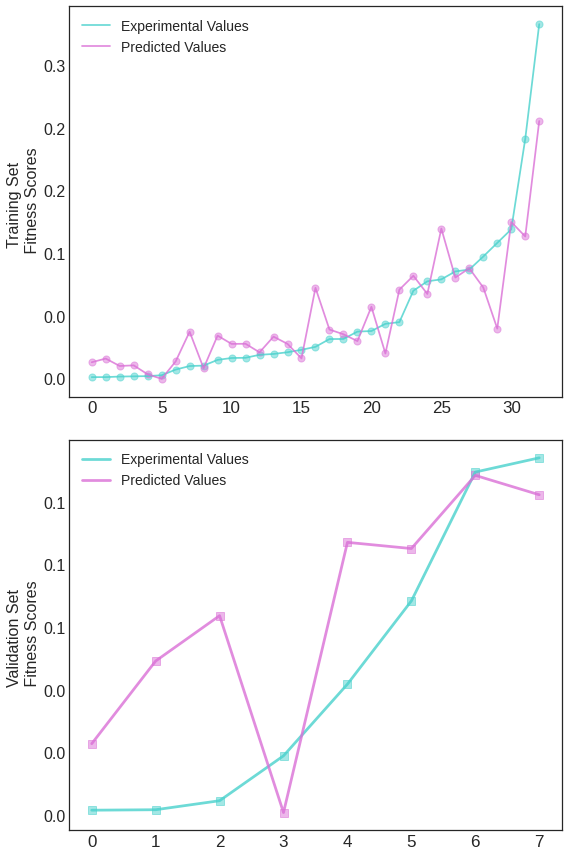

In [28]:
X_train = training_df.loc[:, training_df.columns[2:]]
Y_train = training_df.loc[:, "fitness"]
X_test = testing_df.loc[:, training_df.columns[2:]]
Y_test = testing_df.loc[:, "fitness"]


Y_train_preds = DE_model.predict(X_train)
Y_test_preds = DE_model.predict(X_test)

print("Train set ranking error: ", confusion_matrix_loss(np.array(Y_train),Y_train_preds))
print("Test set ranking error: ", confusion_matrix_loss(np.array(Y_test),Y_test_preds))


fig = plt.figure(figsize=(8,12))

ax1 = fig.add_subplot(2,1,1)
ax1.plot(np.arange(len(Y_train)), np.array(Y_train)[np.argsort(Y_train)],color='mediumturquoise',linewidth=1.75, alpha=0.8)
ax1.plot(np.arange(len(Y_train)), np.array(Y_train_preds)[np.argsort(Y_train)],color='orchid',linewidth=1.75, alpha=0.8)


ax1.scatter(np.arange(len(Y_train)), np.array(Y_train)[np.argsort(Y_train)],color='mediumturquoise',s=50, alpha=0.5)
ax1.scatter(np.arange(len(Y_train)), np.array(Y_train_preds)[np.argsort(Y_train)],color='orchid',s=50, alpha=0.5)


ax2 = fig.add_subplot(2,1,2)
ax2.plot(np.arange(len(Y_test)), np.array(Y_test)[np.argsort(Y_test)],color='mediumturquoise',linewidth=2.75, alpha=0.8)
ax2.plot(np.arange(len(Y_test)), np.array(Y_test_preds)[np.argsort(Y_test)],color='orchid',linewidth=2.75, alpha=0.8)

ax2.scatter(np.arange(len(Y_test)), np.array(Y_test)[np.argsort(Y_test)],color='mediumturquoise',s=50, alpha=0.5,marker="s")
ax2.scatter(np.arange(len(Y_test)), np.array(Y_test_preds)[np.argsort(Y_test)],color='orchid',s=50, alpha=0.5,marker="s")




ax1.set_ylabel("Training Set \n Fitness Scores",size=16)
ax2.set_ylabel("Validation Set \n Fitness Scores",size=16)


ax1.set_yticklabels(np.round(ax1.get_yticks(),1),fontsize=16)
ax2.set_yticklabels(np.round(ax2.get_yticks(),1),fontsize=16)



ax1.set_xticklabels(ax1.get_xticks().astype(int),fontsize=17)
ax2.set_xticklabels(ax2.get_xticks().astype(int),fontsize=17)


fig.tight_layout(w_pad=2.5, h_pad=2.5)

ax1.legend(['Experimental Values','Predicted Values'],fontsize=14)
ax2.legend(['Experimental Values','Predicted Values'],fontsize=14)


plt.show()

In [30]:
# define the wild-type sequence
s_wt = target_sequence


DE_record_folder = f'{RES_DIR_SEQ_OUT}/P450_DE_test_100' # assign project name for the simulation

os.makedirs(DE_record_folder, exist_ok=True)
T = 0.01 # "temperature" parameter: determines sensitivity of Metropolis-Hastings acceptance criteria
num_iterations = 25 # how many subsequent mutation trials per simulated evolution trajectory
num_trajectories = 100 # how many separate evolution trajectories to run

14 A->V
7 G->Y
8 L->Y
7 Y->E
3 T->W
2 M->L
9 A->Y
4 I->W
15 S->W
21 N->H
23 E->E
23 E->V
26 S->W
25 D->E
29 N->G
finished trajectory # 0
450 K->T
447 R->N
455 A->C
459 G->R
467 Y->E
474 E->T
464 D->C
461 R->H
460 L->N
458 H->N
455 C->D
452 G->N
447 N->C
441 F->R
453 K->T
454 D->Y
448 K->P
finished trajectory # 1
253 D->D
247 G->F
249 K->E
249 E->A
250 I->I
248 V->Q
245 A->A
260 K->T
262 K->L
258 Q->K
262 L->A
257 Q->Q
256 G->Y
252 E->E
257 Q->E
250 N->N
finished trajectory # 2
80 I->Y
76 L->E
71 I->T
63 R->G
57 V->N
59 P->K
64 K->M
70 M->S
77 A->N
73 K->H
66 K->M
59 K->Y
67 E->T
61 I->C
63 G->M
63 M->G
71 T->T
finished trajectory # 3
80 P->E
70 V->A
75 C->F
76 L->I
90 N->M
96 Q->M
98 G->G
84 S->L
79 S->R
84 L->P
63 R->I
62 Q->G
finished trajectory # 4
329 W->S
325 G->K
317 R->R
307 K->D
301 D->Q
308 E->C
293 T->E
307 D->H
311 A->Q
314 E->V
315 A->T
319 A->W
317 R->R
311 Q->N
finished trajectory # 5
305 D->A
310 E->K
311 A->N
316 F->C
317 R->E
308 E->A
294 M->N
301 D->Q
304 R->N
300 M->

<Figure size 432x288 with 0 Axes>

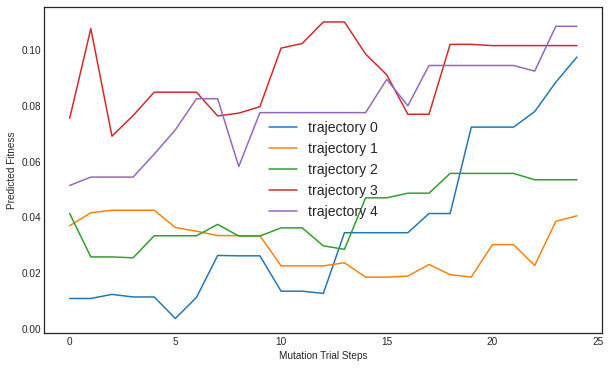

<Figure size 432x288 with 0 Axes>

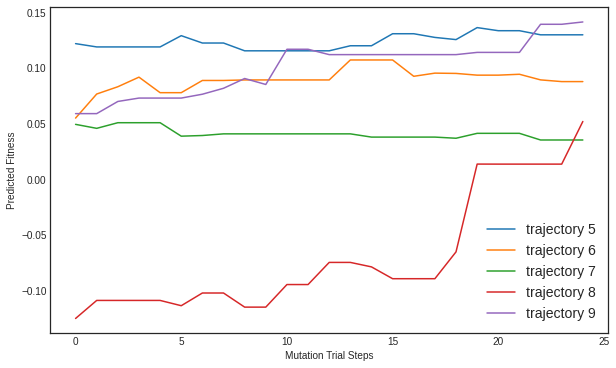

<Figure size 432x288 with 0 Axes>

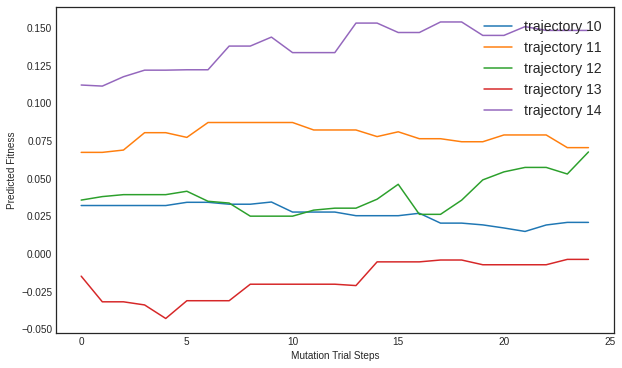

<Figure size 432x288 with 0 Axes>

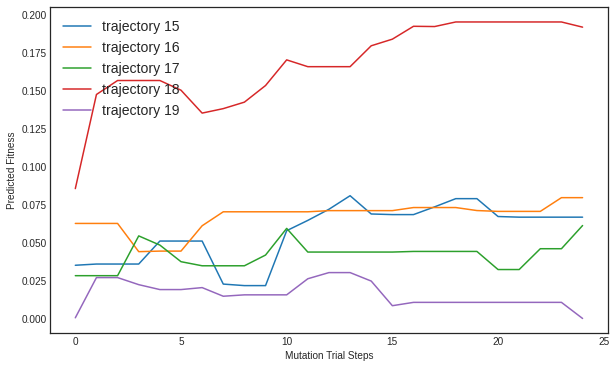

<Figure size 432x288 with 0 Axes>

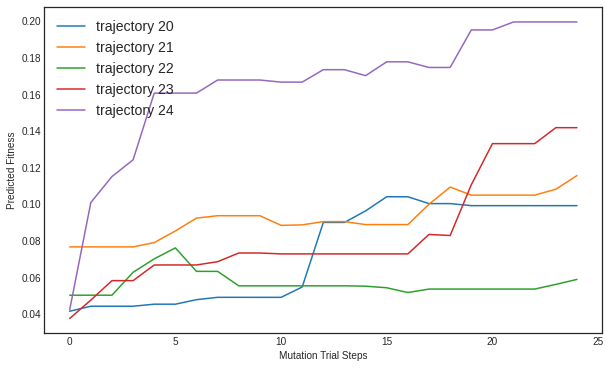

<Figure size 432x288 with 0 Axes>

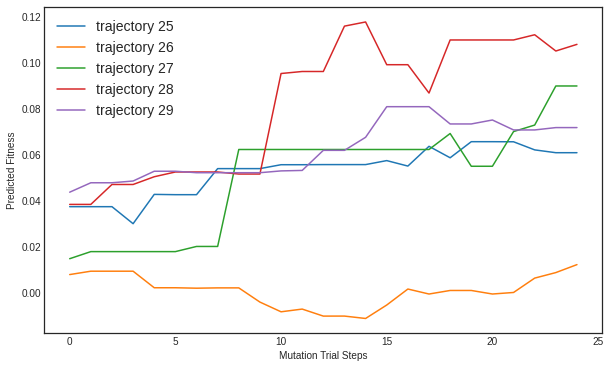

<Figure size 432x288 with 0 Axes>

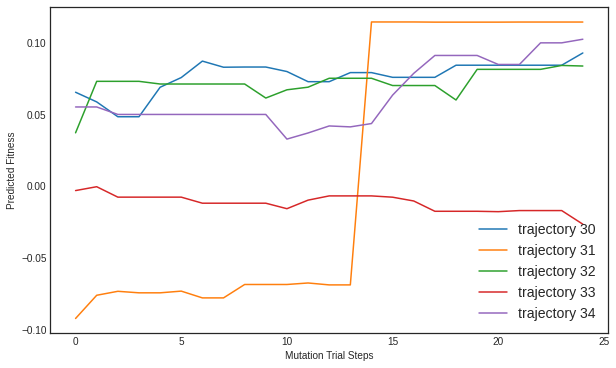

<Figure size 432x288 with 0 Axes>

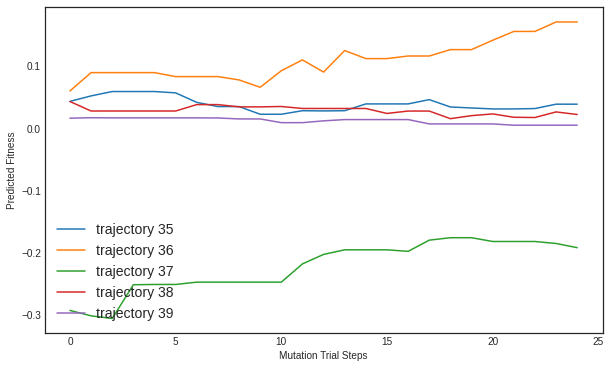

<Figure size 432x288 with 0 Axes>

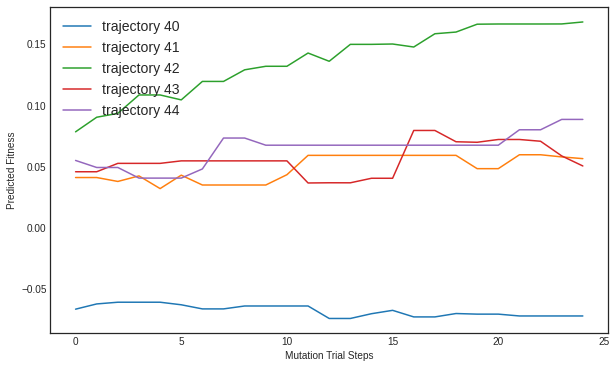

<Figure size 432x288 with 0 Axes>

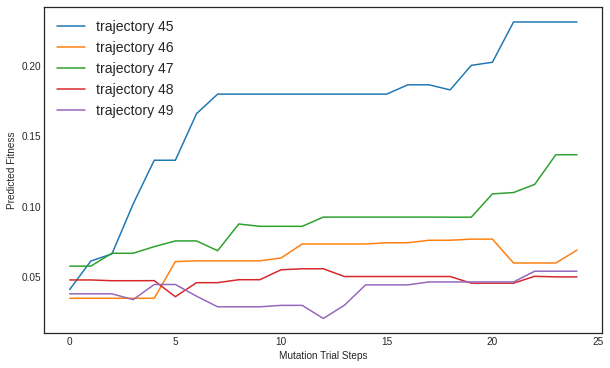

<Figure size 432x288 with 0 Axes>

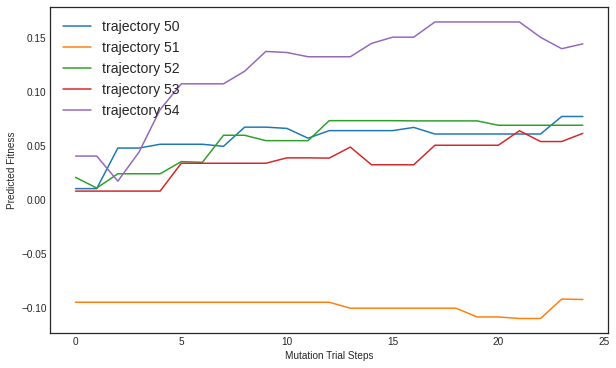

<Figure size 432x288 with 0 Axes>

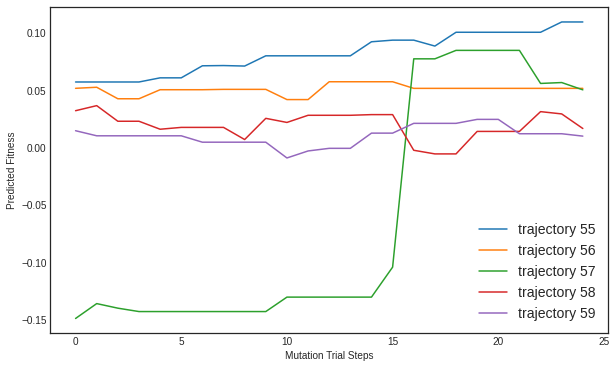

<Figure size 432x288 with 0 Axes>

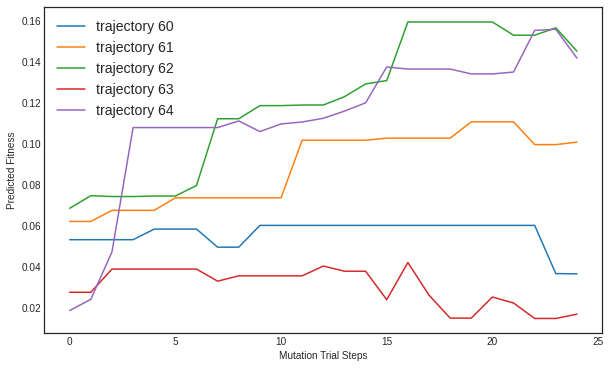

<Figure size 432x288 with 0 Axes>

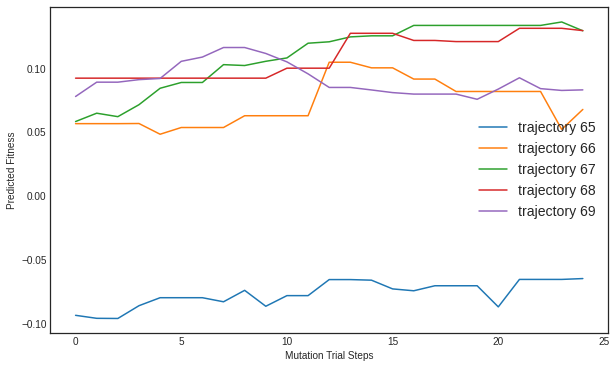

<Figure size 432x288 with 0 Axes>

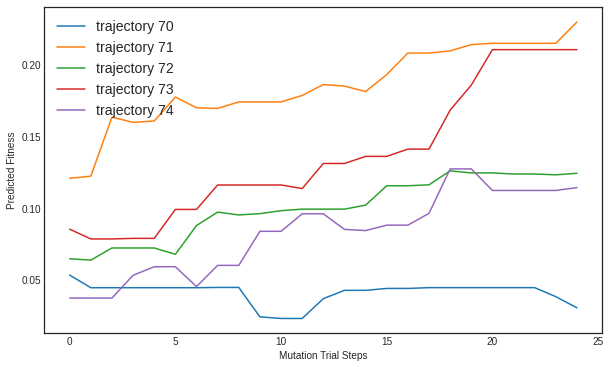

<Figure size 432x288 with 0 Axes>

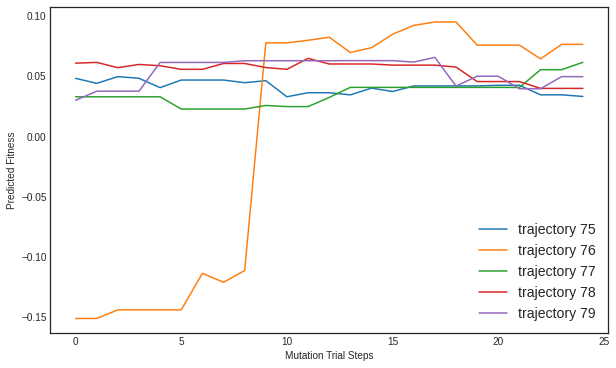

<Figure size 432x288 with 0 Axes>

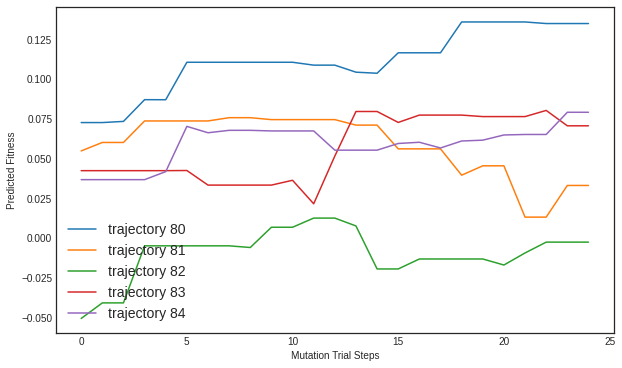

<Figure size 432x288 with 0 Axes>

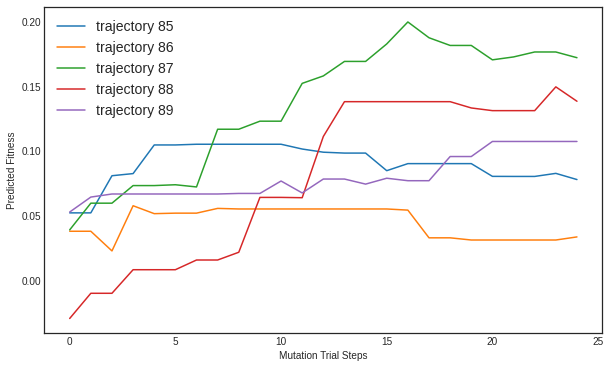

<Figure size 432x288 with 0 Axes>

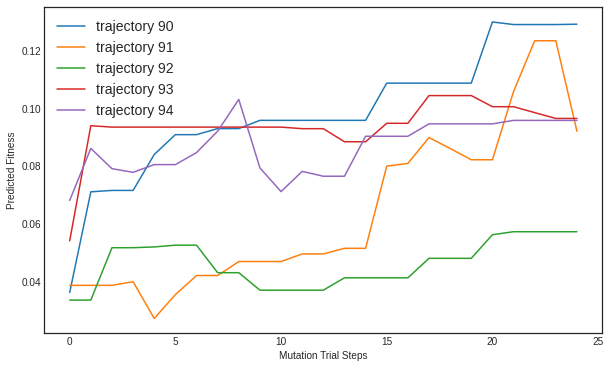

<Figure size 432x288 with 0 Axes>

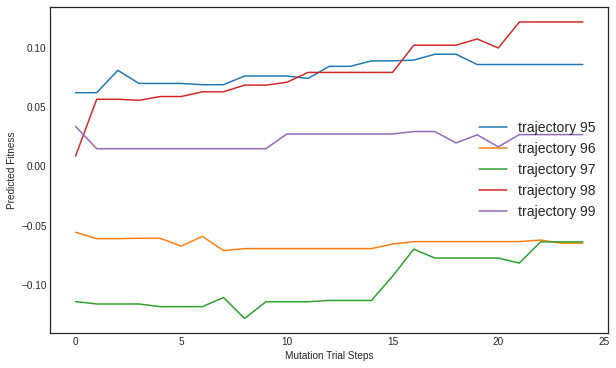

In [31]:
s_records, y_records = run_DE_trajectories(s_wt, DE_model, T, num_iterations, num_trajectories, DE_record_folder, params ,save=True)

In [36]:
tared_file='P450_low-n_direct_evolution.tar.bz'
os.system(f'cd {DE_record_folder} && tar jcvf {tared_file} * ;mv {tared_file} ..')
files.download(f'{RES_DIR_SEQ_OUT}/{tared_file}')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>